In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from typing import Tuple

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, auc
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler

plt.style.use('fast')

In [14]:
path = '/Users/alvarochapela/Documents/DATOS_ZRIVE/Module2Data/'
dataframe = pd.read_csv(path + 'feature_frame.csv')
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2880549 entries, 0 to 2880548
Data columns (total 27 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   variant_id                        int64  
 1   product_type                      object 
 2   order_id                          int64  
 3   user_id                           int64  
 4   created_at                        object 
 5   order_date                        object 
 6   user_order_seq                    int64  
 7   outcome                           float64
 8   ordered_before                    float64
 9   abandoned_before                  float64
 10  active_snoozed                    float64
 11  set_as_regular                    float64
 12  normalised_price                  float64
 13  discount_pct                      float64
 14  vendor                            object 
 15  global_popularity                 float64
 16  count_adults                      fl

In [15]:
dataframe.head()

,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,...,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
0,33826472919172,ricepastapulses,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
1,33826472919172,ricepastapulses,2808027644036,3466586718340,2020-10-05 17:59:51,2020-10-05 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
2,33826472919172,ricepastapulses,2808099078276,3481384026244,2020-10-05 20:08:53,2020-10-05 00:00:00,4,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
3,33826472919172,ricepastapulses,2808393957508,3291363377284,2020-10-06 08:57:59,2020-10-06 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
4,33826472919172,ricepastapulses,2808429314180,3537167515780,2020-10-06 10:37:05,2020-10-06 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618


In [16]:
info_cols = set(['variant_id', 'order_id', 'user_id', 'created_at', 'order_date'])
label_col = 'outcome'

feature_cols_set = set(dataframe.columns) - info_cols - set([label_col])
features_cols = list(feature_cols_set)  

categorical_cols = set(['product_type', 'vendor'])
binary_cols = set(['ordered_before', 'abandoned_before', 'active_snoozed', 'set_as_regular'])

numerical_cols_set = feature_cols_set - categorical_cols - binary_cols
numerical_cols = list(numerical_cols_set)  


In [20]:
def filter_orders_by_size(dataframe, min_products=5):
    """Only orders with at least min_products"""
    # Calculate the total number of products per order
    order_sizes = dataframe.groupby('order_id')['outcome'].sum()
    # Find the orders that meet the minimum size requirement
    large_orders = order_sizes[order_sizes >= min_products].index
    # Filter the original DataFrame to only include these orders
    return dataframe[dataframe['order_id'].isin(large_orders)]

def convert_to_datetime(dataframe, column_name):
    """Convert a column to datetime."""
    dataframe.loc[column_name] = pd.to_datetime(dataframe[column_name])
    return dataframe

def convert_to_date(dataframe, column_name):
    """Convert a column to just date, no time."""
    dataframe.loc[column_name] = pd.to_datetime(dataframe[column_name]).dt.date
    return dataframe

# Apply the functions to the DataFrame
df_filtered = filter_orders_by_size(dataframe)
df_filtered = convert_to_datetime(df_filtered, 'created_at')
df_selected = convert_to_date(df_filtered, 'order_date')


/var/folders/pw/b4ryzt9s5c5g1n_snb_j6yxw0000gn/T/ipykernel_80593/3750389262.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.loc[column_name] = pd.to_datetime(dataframe[column_name])
/var/folders/pw/b4ryzt9s5c5g1n_snb_j6yxw0000gn/T/ipykernel_80593/3750389262.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.loc[column_name] = pd.to_datetime(dataframe[column_name]).dt.date


Compruebo el tamaño del nuevo dataframe a ver si es menor que el normal

In [21]:
df_selected.order_id.nunique() < dataframe.order_id.nunique()

True

In [23]:
daily_orders = df_selected.groupby('order_date').order_id.nunique()
daily_orders.head()

order_date
2020-10-05 00:00:00     3
2020-10-06 00:00:00     7
2020-10-07 00:00:00     6
2020-10-08 00:00:00    12
2020-10-09 00:00:00     4
Name: order_id, dtype: int64

Text(0.5, 1.0, 'Daily orders')

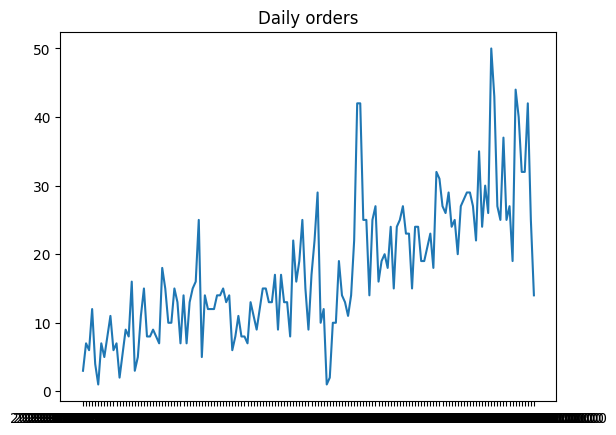

In [26]:
plt.plot(daily_orders)
plt.title("Daily orders")

Como hay una clara evolución temporal de los datos, vamos a hacer un split temporal para train, validation y training

In [27]:
cumulative_percentage = daily_orders.cumsum() / daily_orders.sum()

train_cutoff_index = cumulative_percentage.searchsorted(0.7)
val_cutoff_index = cumulative_percentage.searchsorted(0.9)

train_val_cutoff = cumulative_percentage.index[train_cutoff_index]
val_test_cutoff = cumulative_percentage.index[val_cutoff_index]

print("Train since:", cumulative_percentage.index.min())
print("Train until:", train_val_cutoff)
print("Val until:", val_test_cutoff)
print("Test until:", cumulative_percentage.index.max())


Train since: 2020-10-05 00:00:00
Train until: 2021-02-05 00:00:00
Val until: 2021-02-23 00:00:00
Test until: 2021-03-03 00:00:00


In [28]:
train_df = df_selected[df_selected.order_date <= train_val_cutoff]
val_df = df_selected[(df_selected.order_date > train_val_cutoff) & (df_selected.order_date <= val_test_cutoff)]
test_df = df_selected[df_selected.order_date > val_test_cutoff]

In [29]:
def plot_metrics(
        model_name, y_pred, y_test, target_precision=0.05, figure=None
    ):
    # Calculate precision and recall for various thresholds
    precision_, recall_, _ = precision_recall_curve(y_test, y_pred)
    # Calculate the area under the precision-recall curve
    pr_auc = auc(recall_, precision_)

    # Calculate the false positive rate and true positive rate for various thresholds
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    # Calculate the area under the ROC curve
    roc_auc = roc_auc_score(y_test, y_pred)

    # If no figure is provided, create a new one
    if figure is None:
        fig, ax = plt.subplots(1, 2, figsize=(14, 7))  # 1 row, 2 columns for subplots
    else:
        fig, ax = figure  # Use the provided figure and axes
        
    # Plot the precision-recall curve on the first subplot
    ax[0].plot(recall_, precision_, label=f"PR Curve (AUC: {pr_auc:.2f})")
    ax[0].set_xlabel("Recall")
    ax[0].set_ylabel("Precision")
    ax[0].set_title("Precision-Recall Curve")
    ax[0].legend(loc='best')  # Show the legend in the best location

    # Plot the ROC curve on the second subplot
    ax[1].plot(fpr, tpr, label=f"ROC Curve (AUC: {roc_auc:.2f})")
    ax[1].set_xlabel("False Positive Rate")
    ax[1].set_ylabel("True Positive Rate")
    ax[1].set_title("ROC Curve")
    ax[1].legend(loc='best')  # Show the legend in the best location
    

In [ ]:
plot_metrics("Popularity baseline", y_pred=val_df["global_popularity"], y_test=val_df[label_col])